1 Optimization
1.1 Preparing model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [2]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [3]:
np.random.seed(0)

In [5]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data<=threshold)/data.shape[0]

SMALLER = 'SMALLER'

def costs(data):
    return data[0]/1e9 # makes numbers nicer

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 10e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN
Total_Investment_Costs = costs #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN

In [6]:
from problem_formulation import get_model_for_problem_formulation

model, _ = get_model_for_problem_formulation(1)

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [8]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [9]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(scenarios=200,
                                                policies=4,
                                                uncertainty_sampling=Samplers.MC)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 3 workers
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
100%|████████████████████████████████████████| 800/800 [04:59<00:00,  2.67it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


NameError: name 'results' is not defined

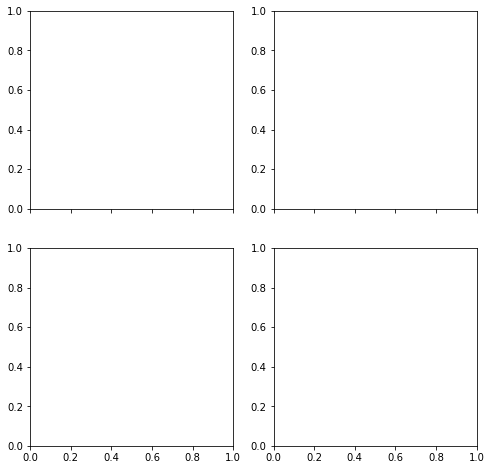

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

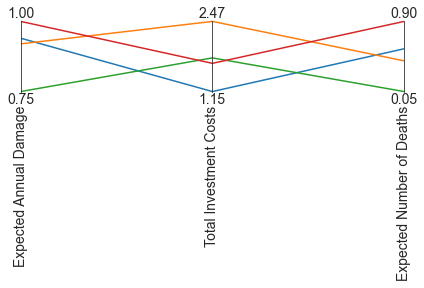

In [ ]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

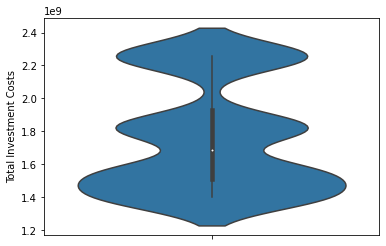

In [10]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Investment Costs')
plt.show()

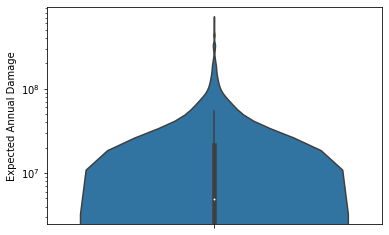

In [11]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

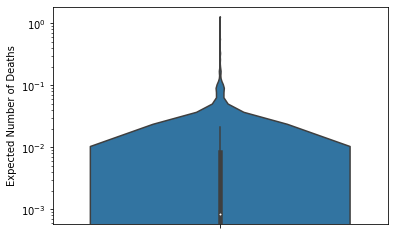

In [12]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

In [11]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress

In [12]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(20000)  # Original value: 1000

In [13]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle4 = False
if use_pickle4:
    with open('data/moro_results4.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [HyperVolume(minimum=[0, 0, 0], maximum=[1.01, 1.01, 3.01]),
    EpsilonProgress(),]

    epsilons=[0.025,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_results4.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive1, convergence = results4

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [14]:
archive1 = archive1.T

archive1

,0
0_RfR 0,1.000000
0_RfR 1,1.000000
0_RfR 2,1.000000
1_RfR 0,1.000000
1_RfR 1,1.000000
1_RfR 2,1.000000
2_RfR 0,1.000000
2_RfR 1,1.000000
2_RfR 2,1.000000
3_RfR 0,1.000000


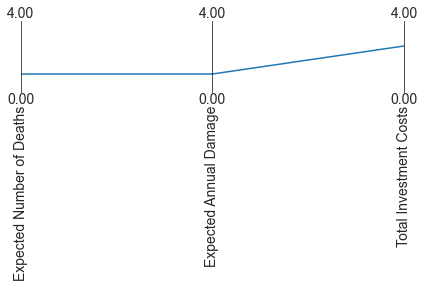

In [16]:
from ema_workbench.analysis import parcoords

data = archive1.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 4

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

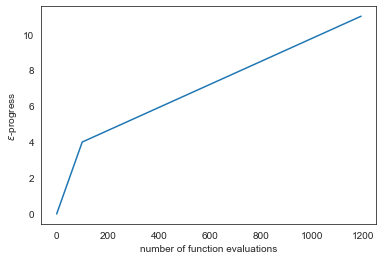

In [14]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

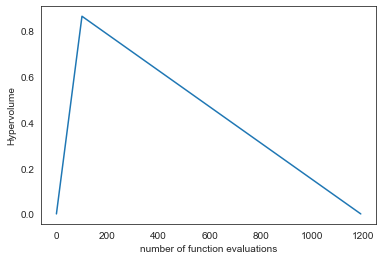

In [15]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.hypervolume)
ax.set_ylabel('Hypervolume')

ax.set_xlabel('number of function evaluations')
plt.show()

Robustness metrics

In [ ]:
archive = pd.read_csv('data\moro_results7_archive.csv')

In [ ]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [ ]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [ ]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))
location = '2'

pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 0, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}0_EWS_4d"))

pol_list.append(create_policy({"A.3_DikeIncrease 0": 0, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{0}dm_RfR_{location}1_EWS_4d"))
                            
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}1_EWS_4d"))    

In [ ]:
policies = archive.iloc[:,:-3]

In [ ]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    pol_list.append(Policy(str(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
model, _ = get_model_for_problem_formulation(3)
use_pickle6 = False
if use_pickle6:
    with open('data/opt_analysis.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                pol_list)
      # Save results in Pickle file
    with open("data/opt_analysis.pickle","wb") as filehandler:
        pickle.dump(results, filehandler) 

In [ ]:
experiments, outcomes = results

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
a = data.columns[data.columns.str.contains('Costs')]
data['Total Costs'] = data[a].sum(axis=1)
a = data.columns[data.columns.str.contains('Deaths')]
data['Total Deaths'] = data[a].sum(axis=1)

data['policy'] = policies

In [ ]:
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [ ]:
pol_list = data['policy'].unique()

count=0
for i in pol_list:
    
    data.loc[data.policy== i, 'policy'] = count
    count+=1

In [ ]:
limits = parcoords.get_limits(data.iloc[:,:-1])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    #print(upper)
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,0.1],
                label = column, values = data[column].values, tickformat = "~g"))

In [ ]:
import plotly

import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

Signal to noise ratio

In [ ]:
#function for signal to nois ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
experiments, outcomes = results

#first iterates over policies then over outcomes to calculate scores
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
#plots the s/n ratio
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [ ]:
data.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True)
data.columns.values[0] = "policy"

In [ ]:
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [ ]:
data2 = data.iloc[::-1,:]

In [ ]:
limits = parcoords.get_limits(data.iloc[:,1::])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,1],
                label = column, values = data[column].values, tickformat = "~g"))

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'],
                   colorscale = [[0,'yellow'],[0.5,'lightseagreen'],[1,'red']], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

Maximum regret

In [ ]:
#function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    coldict = {'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D', 'RfR Total Costs': 'RfR', 'Expected Evacuation Costs':'Evac Costs'}

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #

    outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[coldict.get(outcome.name)] = outcome_regret
    max_regret[coldict.get(outcome.name)] = outcome_regret.max()

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [ ]:
colors = sns.color_palette()

data = max_regret

limits = parcoords.get_limits(data)
limits.loc[0, ['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
       '5.D', 'RfR', 'Evac Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()